# <u style = "color: red;"><p style = "color: red;"> ***Classification Model*** </p></u> 

### Imports

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [42]:
df = pd.read_csv('clean_data.csv')
df['treatment'].value_counts()

treatment
Yes    631
No     619
Name: count, dtype: int64

### Params Grid for multiple models

In [43]:
models = {
    'LogReg': (LogisticRegression(random_state=42, max_iter=10000, penalty='l2', solver='lbfgs'), {
        'C': [0.01, 0.1, 1, 10]
    }),
    'SVC': (SVC(random_state=42, kernel='rbf', C=10, gamma='scale'), {
    }),
    'KNN': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }),
    'RF': (RandomForestClassifier(random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7, None]
    }),
    'XGB': (XGBClassifier(eval_metric='logloss', random_state=42), {  
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0],
        'max_depth': [3, 5, 7]
    })
}

### Splitting Data

In [44]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['treatment'], axis=1)
y = df['treatment'].map({'Yes': 1, 'No': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_cols = ['Age']
categorical_cols = X.drop(columns=['Age']).columns

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

### Fitting the Model

In [45]:
best_score = 0
best_model = None
best_name = None

for name, (model, params) in models.items():
    grid = GridSearchCV(model, param_grid=params, cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train_encoded, y_train)
    print(f"{name} Best Params: {grid.best_params_}")
    print(f"{name} Best CV Score: {grid.best_score_}\n")
    
    if grid.best_score_ > best_score:
        best_score = grid.best_score_
        best_model = grid.best_estimator_
        best_name = name

print(f"\nBest Model: {best_name} with F1 = {best_score}")

LogReg Best Params: {'C': 0.1}
LogReg Best CV Score: 0.725378382792604

SVC Best Params: {}
SVC Best CV Score: 0.6909245527612133

KNN Best Params: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
KNN Best CV Score: 0.6289816591040377

RF Best Params: {'max_depth': None, 'n_estimators': 200}
RF Best CV Score: 0.7480425377918831

XGB Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
XGB Best CV Score: 0.752083385831377


Best Model: XGB with F1 = 0.752083385831377


### Evaluation of the model

In [46]:
#Classification Report

from sklearn.metrics import accuracy_score
y_pred = best_model.predict(X_test_encoded)
y_score = best_model.predict_proba(X_test_encoded)[:, 1]

print(classification_report(y_test, y_pred))
print(f"Accuracy: {(accuracy_score(y_test, y_pred)*100):.3f}%")

              precision    recall  f1-score   support

           0       0.76      0.78      0.77       115
           1       0.81      0.79      0.80       135

    accuracy                           0.78       250
   macro avg       0.78      0.78      0.78       250
weighted avg       0.78      0.78      0.78       250

Accuracy: 78.400%


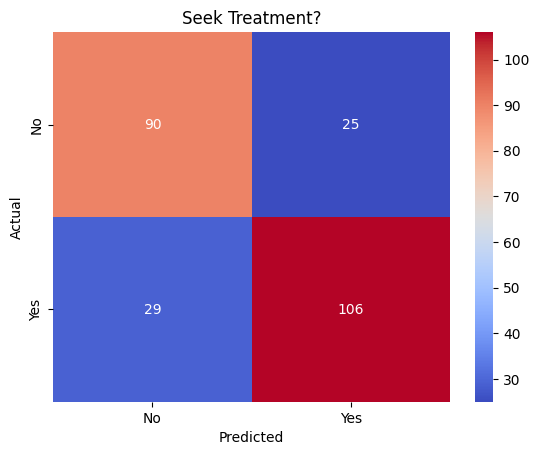

In [47]:
#Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
labels = ['No', 'Yes']
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Seek Treatment?")
plt.show()

In [48]:
#ROC-AUC Score

from sklearn.metrics import roc_auc_score
print(f"ROC-AUC Score: {(roc_auc_score(y_test, y_score)*100):.3f}%")

ROC-AUC Score: 81.201%


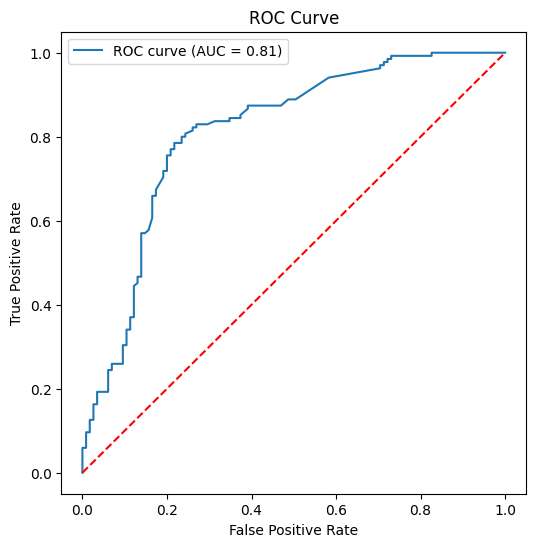

In [49]:
#ROC Curve

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [50]:
import joblib
joblib.dump(best_model, 'classification_model.pkl')
joblib.dump(preprocessor, 'classification_preprocessor.pkl')

['classification_preprocessor.pkl']

### Conclusion:-

The XG Boost classifier model gave the best results, this can be inferred by comparing the scores of all models.


F1 = 0.752083385831377


Accuracy: 78.400%


ROC-AUC Score: 81.201%